In [1]:
from pylab import *
%matplotlib inline

# Loading Data

In [2]:
!gunzip -v ../data/K562_2000_merged_histones_init.csv.gz -c > ../data/K562_2000_merged_histones_init.csv

../data/K562_2000_merged_histones_init.csv.gz:	 76.4%


In [3]:
import pandas as pd
from repli1d.nn import load_signal,transform_norm,train_test_split,transform_seq,create_model
name="../data/K562_2000_merged_histones_init.csv"
marks = [ "H3K4me1", "H3K4me3", "H3K27me3", "H3K36me3",
                         "H3K9me3","H2A.Z","H3K79me2","H3K9ac","H3K4me2","H3K27ac","H4K20me1"]
df, yinit, notnan = load_signal(name,
                                marks=marks,
                                targets=["initiation"],
                                 t_norm=transform_norm, smm=5,wig=False)
#XC = pd.read_csv(root + "coords_K562.csv", sep="\t")  # List of chromosome coordinates
#traint =  [1,2,3,4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] +[20, 21, 22, 23]

#train, test = train_test_split(XC, traint, valt, notnan)
X_train_us, y_train_us = df , yinit

window=101
vtrain = transform_seq(X_train_us, y_train_us, 1, window)
print(vtrain[0].shape,vtrain[1].shape)

You may need to install pyBigWig
         initiation       H3K4me1       H3K4me3      H3K27me3      H3K36me3  \
count  1.440505e+06  1.440505e+06  1.440505e+06  1.440505e+06  1.440505e+06   
mean   9.976736e-01  1.743105e+01  1.385608e+01  1.262667e+01  1.386203e+01   
std    2.943455e+00  3.547314e+01  4.096911e+01  1.356939e+01  1.990559e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.033000e-01  4.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00   
50%    2.160000e-01  7.000000e+00  8.000000e+00  9.000000e+00  8.000000e+00   
75%    5.352000e-01  1.500000e+01  1.200000e+01  1.600000e+01  1.400000e+01   
max    5.712940e+01  1.657000e+03  2.353000e+03  1.562000e+03  1.576000e+03   

            H3K9me3         H2A.Z      H3K79me2        H3K9ac       H3K4me2  \
count  1.440505e+06  1.440505e+06  1.440505e+06  1.440505e+06  1.440505e+06   
mean   2.009775e+01  2.315037e+01  2.184659e+01  1.761894e+01  1.295846e+01   
std    1.492397e+0

In [11]:
df

,H3K4me1,H3K4me3,H3K27me3,H3K36me3,H3K9me3,H2A.Z,H3K79me2,H3K9ac,H3K4me2,H3K27ac,H4K20me1
0,-0.033333,-0.028571,-0.025,-0.028571,-0.0375,-0.018182,-0.033333,-0.025,0.0,0.0,-0.036364
1,-0.033333,-0.028571,-0.025,-0.028571,-0.0375,-0.018182,-0.033333,-0.025,0.0,0.0,-0.036364
2,-0.033333,-0.028571,-0.025,-0.028571,-0.0375,-0.018182,-0.033333,-0.025,0.0,0.0,-0.036364
3,-0.033333,-0.028571,-0.025,-0.028571,-0.0375,-0.018182,-0.033333,-0.025,0.0,0.0,-0.036364
4,-0.033333,-0.028571,-0.025,-0.028571,-0.0375,-0.018182,-0.033333,-0.025,0.0,0.0,-0.036364
...,...,...,...,...,...,...,...,...,...,...,...
1440500,-0.033333,-0.028571,-0.025,-0.028571,-0.0375,-0.018182,-0.033333,-0.025,0.0,0.0,-0.036364
1440501,-0.033333,-0.028571,-0.025,-0.028571,-0.0375,-0.018182,-0.033333,-0.025,0.0,0.0,-0.036364
1440502,-0.033333,-0.028571,-0.025,-0.028571,-0.0375,-0.018182,-0.033333,-0.025,0.0,0.0,-0.036364
1440503,-0.033333,-0.028571,-0.025,-0.028571,-0.0375,-0.018182,-0.033333,-0.025,0.0,0.0,-0.036364


# Loading the network
command line to train it:
```
python src/repli1d/nn.py  --noenrichment --targets initiation --root training_dir/nn_K562_2000/ --listfile data/K562_2000_merged_histones_init.csv  --window 101 --wig 0 --predict_files data/K562_2000_merged_histones_init.csv --marks H3K4me1 H3K4me3 H3K27me3 H3K36me3 H3K9me3 H2A.Z H3K79me2 H3K9ac H3K4me2 H3K27ac H4K20me1 --datafile```

In [4]:
import keras

model = keras.models.load_model("../data/nn_K562_marks.hdf5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 92, 15)         1665      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 92, 15)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 92, 15)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 83, 15)         2265      
_________________________________________________________________
activation_2 (Activation)    (None, 1, 83, 15)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 83, 15)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 74, 15)        

In [5]:
data_start = model.predict(vtrain[0][:4000])

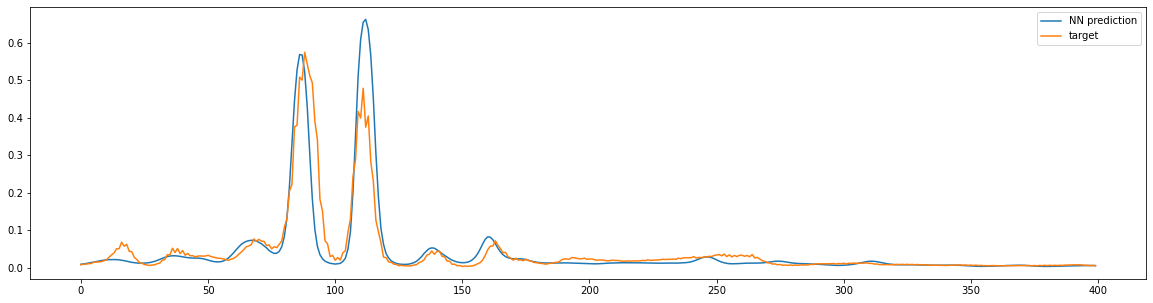

In [10]:
figure(figsize=(20,5))
plot(vtrain[1][1700:2100],label="NN prediction")
plot(data_start[1700:2100],label="target")
legend()